In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

In [7]:
folder_path = 'images'
images = []
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        images.append(img)

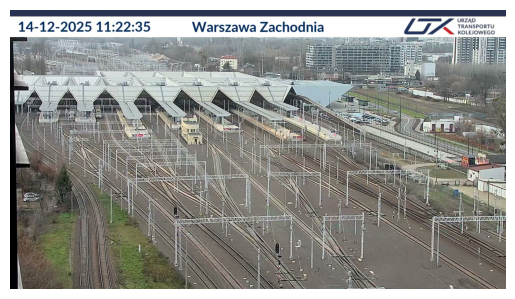

In [4]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

In [4]:
from img2vec_pytorch import Img2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def encode_and_do_pca_all(encoder, images):
    vectors = []
    for img in images:
        vec = encoder.get_vec(img)
        vectors.append(vec)

    vectors = np.vstack(vectors)
    print("Vector shape:", vectors.shape)

    pca = PCA(n_components=2)
    vectors_reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(6,6))
    plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], color='blue', s=5)
    plt.title('PCA analysis of all images')
    plt.show()

In [11]:
len(images)

1347

In [8]:
print("CUDA dostępna:", torch.cuda.is_available())
print("Liczba GPU:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("Nazwa GPU:", torch.cuda.get_device_name(0))

CUDA dostępna: True
Liczba GPU: 4
Nazwa GPU: NVIDIA RTX A6000


In [12]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*28*28, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128*28*28), nn.ReLU(),
            nn.Unflatten(1,(128,28,28)),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,3,stride=2,padding=1,output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

In [14]:
class AutoencoderVec:
    def __init__(self, autoencoder, transform):
        self.model = autoencoder
        self.model.eval()
        self.transform = transform
        
    def get_vec(self, img: Image.Image):
        img_t = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _, z = self.model(img_t)
        return z.squeeze().numpy()

In [15]:
image_tensors = [transform(img) for img in images]
image_batch = torch.stack(image_tensors)

In [22]:
ae = Autoencoder(latent_dim=128)
optimizer = torch.optim.Adam(ae.parameters())
criterion = nn.MSELoss()

In [23]:
num_epochs = 32
losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon, _ = ae(image_batch)
    loss = criterion(recon, image_batch)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0371
Epoch 2, Loss: 0.0370
Epoch 3, Loss: 0.0368
Epoch 4, Loss: 0.0363
Epoch 5, Loss: 0.0357
Epoch 6, Loss: 0.0345
Epoch 7, Loss: 0.0326
Epoch 8, Loss: 0.0301
Epoch 9, Loss: 0.0273
Epoch 10, Loss: 0.0246
Epoch 11, Loss: 0.0226
Epoch 12, Loss: 0.0206
Epoch 13, Loss: 0.0189
Epoch 14, Loss: 0.0171
Epoch 15, Loss: 0.0157
Epoch 16, Loss: 0.0143
Epoch 17, Loss: 0.0133
Epoch 18, Loss: 0.0124
Epoch 19, Loss: 0.0116
Epoch 20, Loss: 0.0108
Epoch 21, Loss: 0.0102
Epoch 22, Loss: 0.0096
Epoch 23, Loss: 0.0091
Epoch 24, Loss: 0.0087
Epoch 25, Loss: 0.0083
Epoch 26, Loss: 0.0080
Epoch 27, Loss: 0.0077
Epoch 28, Loss: 0.0074
Epoch 29, Loss: 0.0071
Epoch 30, Loss: 0.0069
Epoch 31, Loss: 0.0067
Epoch 32, Loss: 0.0065


Vector shape: (1347, 128)


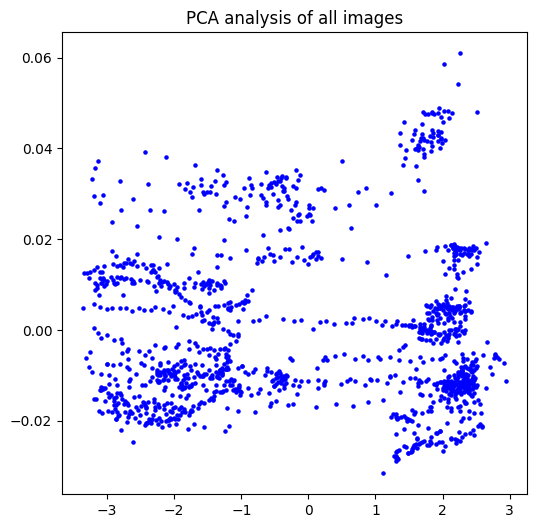

In [24]:
ae_encoder = AutoencoderVec(ae, transform)
encode_and_do_pca_all(ae_encoder, images)

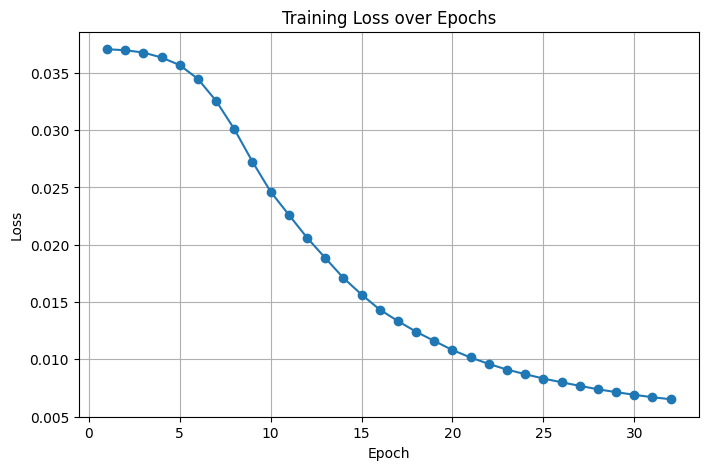

In [25]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()